## 단일 에이전트로 ChatGPT 만들어 보기
이미지 생성 어시스턴트

In [1]:
from dotenv import load_dotenv
import os

load_dotenv()

True

### 이미지 생성 도구

In [2]:
from openai import OpenAI
from pydantic import BaseModel, Field
from langchain_core.tools import tool

client = OpenAI()

# DALL-E 이미지 생성을 위한 스키마 정의
class GenImageSchema(BaseModel):
    prompt: str = Field(description="The prompt for image generation")

# DALL-E 이미지 생성 함수 정의
@tool(args_schema=GenImageSchema)
def generate_image(prompt: str) -> str:
    """
    Generate an image using DALL-E based on the given prompt.
    """
    response = client.images.generate(
        model="dall-e-3",
        prompt=prompt,
        size="1024x1024",
        quality="standard",
        n=1
    )
    return response.data[0].url

### 챗봇

In [3]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.prompts import ChatPromptTemplate, SystemMessagePromptTemplate, HumanMessagePromptTemplate
from datetime import datetime
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0
)

system_prompt = f"""
Today is {datetime.now().strftime("%Y-%m-%d")}
You are a helpful AI Assistant that can use web search tool(tavily ai api) and image generation tool(DallE API).
You should always answer in same language as user's ask.
When user ask about the information that you can't answer, you should call the search tool.
When user ask about generating image, you should call the generate_image tool.

web search tool is useful when:
- real-time info
- local specialized info
- metric related info

you should use web search tool with the guideline below:
- Extract the user query's intent and rephrase the prompt into appropriate search query
- web search tool(Tavily AI API) can deal with sentence query. 
- you don't need to limit your querying ability to generating keyword only query.

generate_image tool is useful when:
Visual Exploration: When you need to visualize abstract concepts, hypothetical scenarios, or creative ideas.
Customization: When you want specific scenes, characters, or objects to be illustrated in detail.
Creative Brainstorming: When generating variations of ideas, styles, or settings to inspire creative work.

Guideline for Using the Image Generation Tool:
Extract the User Query's Intent:
Determine what the user wants to see or visualize. Identify the main subject, style preferences, context, and specific elements they are interested in.
Pay attention to any specific adjectives, details, or emotions that the user emphasizes.
Look for clues about desired art styles, color themes, or scenarios.

Rephrase the Prompt into a Detailed Image Generation Query:
Include relevant details about the main subject, setting, perspective, style, and any additional objects or themes.
Use natural language to clearly describe what the scene should look like, emphasizing the desired atmosphere, colors, and mood.
If the user provides vague descriptions, add assumptions based on common interpretations or clarify with a follow-up.
"""

prompt = ChatPromptTemplate.from_messages([
    SystemMessagePromptTemplate.from_template(system_prompt),
    HumanMessagePromptTemplate.from_template("{input}")
])

search = TavilySearchResults(max_results=5)

tools = [search, generate_image]
llm_with_tools = llm.bind_tools(tools)

chain = prompt | llm_with_tools

/var/folders/l_/8kygc87n5q1d13jbjvmg1mdm0000gn/T/ipykernel_53507/978189052.py:50: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  search = TavilySearchResults(max_results=5)


In [4]:
result = chain.invoke("generate the image of dog")
print(result)

content='' additional_kwargs={'tool_calls': [{'id': 'call_PZIFevQ63Q0G3Q9x7tmhN1H0', 'function': {'arguments': '{"prompt":"A realistic and detailed illustration of a happy dog playing in a sunny park. The dog is a golden retriever with a shiny coat, wagging its tail, surrounded by green grass and colorful flowers. In the background, there are trees and a clear blue sky, creating a cheerful and vibrant atmosphere."}', 'name': 'generate_image'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 73, 'prompt_tokens': 494, 'total_tokens': 567, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'finish_reason': 'tool_calls', 'logprobs': None} id='run--f989b784-50d2-4644-b681-4ab6841195d7-0' tool_calls=[{'name': 'gener

In [5]:
print(result.additional_kwargs['tool_calls'][0]['function']['arguments'])

{"prompt":"A realistic and detailed illustration of a happy dog playing in a sunny park. The dog is a golden retriever with a shiny coat, wagging its tail, surrounded by green grass and colorful flowers. In the background, there are trees and a clear blue sky, creating a cheerful and vibrant atmosphere."}


### 그래프 생성

In [6]:
from typing import Annotated, TypedDict
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition

class State(TypedDict):
    messages: Annotated[list, add_messages]

def chatbot(state: State):
    return {"messages": [chain.invoke(state["messages"])]}

graph_builder = StateGraph(State)

graph_builder.add_node("chatbot", chatbot)

# 도구 노드 추가
tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

# 조건부 엣지 추가
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)

# 도구 호출 후 채팅봇으로 돌아가는 엣지 추가
graph_builder.add_edge("tools", "chatbot")

# 시작점 설정
graph_builder.add_edge(START, "chatbot")

# 그래프 컴파일
graph = graph_builder.compile()

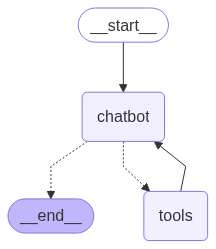

In [7]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [8]:
# The config is the **second positional argument** to stream() or invoke()!
config = {"configurable": {"thread_id": "1"}}

events = graph.stream(
    {"messages": [("user", input("User: "))]}, config, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Claude의 computer use에 대해서 조사하고, 이를 그림으로 표현해줘.
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_W56LH5nUv3mlplyOZPjPnCyi)
 Call ID: call_W56LH5nUv3mlplyOZPjPnCyi
  Args:
    query: Claude computer use
  generate_image (call_Um841APQUU0CyVEve2hBanpr)
 Call ID: call_Um841APQUU0CyVEve2hBanpr
  Args:
    prompt: A creative illustration depicting a character named Claude using a computer. The scene shows Claude sitting at a desk, focused on the screen, with various tech gadgets around him. The atmosphere is modern and vibrant, with colorful lights and a cozy workspace. Claude is portrayed as an inquisitive and engaged individual, reflecting a sense of curiosity and creativity.
================================= Tool Message =================================
Name: generate_image

https://oaidalleapiprodscus.blob.core.windows.net/privat